# Load and split the data

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data set
spam_dataset = pd.read_csv('/content/spam.data.txt', header=None, delim_whitespace=True)
print(spam_dataset.shape, list(spam_dataset.columns.values))

y = spam_dataset.iloc[:,-1]
X = spam_dataset.drop([57], axis = 1)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4601, 58) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
(4601, 57) (4601,)
(3220, 57) (1381, 57) (3220,) (1381,)


# Decision tree implementation

In [ ]:

# Structure of a single node in the decision tree
class TreeNode():
    def __init__(self, left_child=None, right_child=None, feature=None, threshold_value = None, class_label=None):
        
        # for internal or decision node
        self.left_child = left_child
        self.right_child = right_child
        self.feature = feature
        self.threshold_value = threshold_value
        
        # This is only applicable to leaf node to capture the class label
        self.class_label = class_label

class DecisionTree():
    def __init__(self, information_gain_strategy, minimum_datapoints_to_split, maximum_height, max_features):
        self.root = None
        self.information_gain_strategy = information_gain_strategy
        self.max_features = max_features

        # These are the parameters to do pre-pruning to avoid overfitting
        self.minimum_datapoints_to_split = minimum_datapoints_to_split
        self.maximum_height = maximum_height

    # Method that recursively gets called and builds the decision tree
    def generate_decision_tree(self, datapoints, current_height):
        number_of_data_points = np.shape(datapoints)[0]

        # Only try to split if the tree has not reached maximum height and there are sufficient no of data points
        if number_of_data_points >= self.minimum_datapoints_to_split and current_height < self.maximum_height:

            # Find the best split that maximizes the information gain
            spliting_details = self.find_best_split_with_threshold(datapoints)

            # Split only if there is valid information gain
            if spliting_details["information_gain"] > 0:
                right_tree = self.generate_decision_tree(spliting_details["datapoints_to_right"], current_height + 1)
                left_tree = self.generate_decision_tree(spliting_details["datapoints_to_left"], current_height + 1)
                return TreeNode(left_tree, right_tree, spliting_details["feature"], spliting_details["threshold_value"])
        
        # Otherwise create a leaf node by majority count
        return TreeNode(class_label = find_class_label_by_majority_vote(datapoints[:,-1]))

    # Method to try all features and their thresolds to find 
    # the best way to split depending on information gain
    def find_best_split_with_threshold(self, datapoints):

        # It stores the details related to best split
        spliting_details = {"information_gain" : float(-np.inf)}
        
        # Randomly sample features of size "max_features"
        randomly_sampled_features = np.random.choice(datapoints.shape[1] - 1, size = self.max_features, replace=False)

        # Check all unique feature values as thresolds for all the features
        for index in randomly_sampled_features:
            for threshold_value in np.unique(datapoints[:, index]):
                
                # Split the dataset by thresold for a given feature
                datapoints_to_left = np.array([datapoint for datapoint in datapoints if datapoint[index] <= threshold_value])
                datapoints_to_right = np.array([datapoint for datapoint in datapoints if datapoint[index] > threshold_value])

                # Modify split details if a better information gain is found
                if len(datapoints_to_left) >= 1 and len(datapoints_to_right) >= 1:
                    information_gain = self.calculate_information_gain(datapoints[:, -1], datapoints_to_left[:, -1], datapoints_to_right[:, -1])
                    if information_gain > spliting_details["information_gain"]:
                        spliting_details["information_gain"]  = information_gain
                        spliting_details["datapoints_to_left"] = datapoints_to_left
                        spliting_details["datapoints_to_right"] = datapoints_to_right
                        spliting_details["feature"] = index
                        spliting_details["threshold_value"] = threshold_value
        return spliting_details

    # Method to compute information gain by "entropy" or "gini index"
    def calculate_information_gain(self, y_parent, y_left_tree, y_right_tree):
        left_child_weight = len(y_left_tree) / len(y_parent)
        right_child_weight = len(y_right_tree) / len(y_parent)
        information_gain = float(-np.inf)
        if self.information_gain_strategy == "entropy":
            information_gain = compute_entropy(y_parent) - (left_child_weight * compute_entropy(y_left_tree) + right_child_weight * compute_entropy(y_right_tree))
        elif self.information_gain_strategy == "gini":
            information_gain = compute_gini_index(y_parent) - (left_child_weight * compute_gini_index(y_left_tree) + right_child_weight * compute_gini_index(y_left_tree))
        return information_gain

    # Method to recursively traverse the decision tree and make prediction for a single data point
    def predict_class(self, datapoint, node):

        # Reached leaf
        if node.class_label != None: 
          return node.class_label

        # Otherwise look into the left or right subtree
        if datapoint[node.feature] <= node.threshold_value:
            return self.predict_class(datapoint, node.left_child)
        else:
            return self.predict_class(datapoint, node.right_child)
    
    # Method to start training or building the decision tree
    def learn(self, training_set):
        self.root = self.generate_decision_tree(training_set, 0)
    
    # Method to predict class for a test instance
    def classify(self, test_instance):
        return self.predict_class(test_instance, self.root)
    
    # Method that returns height of the decision tree
    def get_height(self, node):
        if node == None or node.class_label != None:
            return 0
        else:
            return max(self.get_height(node.left_child), self.get_height(node.right_child)) + 1

####################################################################################################################

# These are some of the utility/library methods which are not specific to any Decision Tree

# Utility method to compute Entropy
def compute_entropy(y):
  entropy = 0
  class_counts = np.asarray(np.unique(y, return_counts=True)).T
  for class_count in class_counts:
    class_probability = class_count[1] / len(y)
    entropy = entropy + ((-1) * class_probability * np.log2(class_probability))
  return entropy

# Utility method to compute Gini index
def compute_gini_index(y):
  gini_impurity = 0
  class_counts = np.asarray(np.unique(y, return_counts=True)).T
  for class_count in class_counts:
    class_probability = class_count[1] / len(y)
    gini_impurity = gini_impurity + (class_probability * class_probability)
  return (1 - gini_impurity)

# Utility method that returns the majority class
def find_class_label_by_majority_vote(y):
  majority_class, majority_class_count = -1, -1
  class_counts = np.asarray(np.unique(y, return_counts=True)).T
  for class_count in class_counts:
    majority_class = class_count[0] if class_count[1] > majority_class_count else majority_class
    majority_class_count = class_count[1] if class_count[1] > majority_class_count else majority_class_count
  return majority_class
    

# Random forest classifier implementation

In [ ]:
import math

class RandomForestClassifierCustom():
    def __init__(self, n_estimators=100, criterion="gini", max_depth=math.inf, min_samples_split=2, max_features="auto", bootstrap=True, max_samples=None, oob_score = False):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.oob_score = oob_score
        self.oob_score_ = None

        # List to hold the decision trees after training
        self.list_of_decision_trees = []

    def compute_oob_score(self, datapoints, out_of_bag_details):
        total_prediction, correct_prediction = 0, 0
        for i in range(datapoints.shape[0]):
            positive, negative = 0, 0
            for j in range(len(self.list_of_decision_trees)):
                if(i in out_of_bag_details[j]):
                    result = self.list_of_decision_trees[j].classify(datapoints[i])
                    if result == 1:
                        positive += 1
                    else: 
                        negative += 1
            if(positive > 0 or negative > 0):
                total_prediction += 1
                if positive > negative:
                    correct_prediction = (correct_prediction + 1) if datapoints[i][-1]==1 else correct_prediction
                else:
                    correct_prediction = (correct_prediction + 1) if datapoints[i][-1]==0 else correct_prediction
        self.oob_score_ = correct_prediction/total_prediction
        print("\nOut-Of-Bag Error and Accuracy: {} and {}".format(1 - self.oob_score_, self.oob_score_))

    def train(self, X, y):
        training_data = np.concatenate((X, np.asarray(y).reshape((y.shape[0], 1))), axis=1)
        bootstrap_data, out_of_bag_details = training_data, []
        for i in range(self.n_estimators):
          if(self.bootstrap):
            bootstrap_indices = np.random.choice(training_data.shape[0], size = self.max_samples, replace=True)
            bootstrap_data = training_data[bootstrap_indices, :]
            if(self.oob_score):
              out_of_bag_details.append(set(range(training_data.shape[0])).difference(set(bootstrap_indices)))
          decision_tree = DecisionTree(self.criterion, self.min_samples_split, self.max_depth, self.max_features)
          decision_tree.learn(bootstrap_data)
          print("\nHeight of the tree number {} : {}".format(i+1, decision_tree.get_height(decision_tree.root)))
          self.list_of_decision_trees.append(decision_tree)

        if(self.bootstrap and self.oob_score):
          self.compute_oob_score(training_data, out_of_bag_details)

    def test(self, X, y):
      test_data = np.concatenate((X, np.asarray(y).reshape((y.shape[0], 1))), axis=1)
      y_pred = np.array([])
      correct_prediction = 0
      for instance in test_data:
        positive, negative = 0, 0
        for decision_tree in self.list_of_decision_trees:
          result = decision_tree.classify(instance)
          if result == 1:
            positive += 1
          else: 
            negative += 1
        if positive > negative:
          y_pred = np.append(y_pred, [1])
          correct_prediction = (correct_prediction + 1) if instance[-1]==1 else correct_prediction
        else:
          y_pred = np.append(y_pred, [0])
          correct_prediction = (correct_prediction + 1) if instance[-1]==0 else correct_prediction
      test_accuracy = correct_prediction/test_data.shape[0]
      print("\nTesting Error and Accuracy: {} and {}".format(1 - test_accuracy, test_accuracy))
      return y_pred, test_accuracy
        

      
    

# Test custom Random forest classifier

In [ ]:
start = time.time()
classifier_custom = RandomForestClassifierCustom(10, "entropy", math.inf, 2, 30, True, 2000, True)
classifier_custom.train(X_train, y_train)
print("\nTime taken to train : ", time.time()-start)
start = time.time()
y_pred, test_accuracy = classifier_custom.test(X_test, y_test)
print("\nTime taken to test : ", time.time()-start)


Height of the tree number 1 : 25

Height of the tree number 2 : 15

Height of the tree number 3 : 20

Height of the tree number 4 : 20

Height of the tree number 5 : 19

Height of the tree number 6 : 19

Height of the tree number 7 : 20

Height of the tree number 8 : 23

Height of the tree number 9 : 17

Height of the tree number 10 : 20

Out-Of-Bag Error and Accuracy: 0.0726933830382106 and 0.9273066169617894

Time taken to train :  499.38061022758484

Testing Error and Accuracy: 0.06299782766111517 and 0.9370021723388848

Time taken to test :  0.0938262939453125


# Test Sklearn Random forest classifier

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

start = time.time()
classifier = RandomForestClassifier(n_estimators=10, criterion="entropy", min_samples_split=2, max_features=30, bootstrap=True, random_state=42, max_samples=2000, oob_score=True)
classifier.fit(X_train, y_train)
print("\nTime taken to train : ", time.time()-start)
start = time.time()
print("\nOut-Of-Bag Error and Accuracy: {} and {}".format(1 - classifier.oob_score_, classifier.oob_score_))
y_pred = classifier.predict(X_test)
print("\nTime taken to test : ", time.time()-start)
print("\nAccuracy: ", metrics.accuracy_score(y_test, y_pred))


Time taken to train :  0.16983795166015625

Out-Of-Bag Error and Accuracy: 0.07298136645962738 and 0.9270186335403726

Time taken to test :  0.00771021842956543

Accuracy:  0.939898624185373


# Sensitivity of the classifier when no of feature changes


====================== Using max_features =  5

Height of the tree number 1 : 30

Height of the tree number 2 : 24

Height of the tree number 3 : 24

Height of the tree number 4 : 27

Height of the tree number 5 : 28

Out-Of-Bag Error and Accuracy: 0.10053916904535365 and 0.8994608309546464

Testing Error and Accuracy: 0.06589427950760318 and 0.9341057204923968

Sensitivity:  0.9080882352941176

====================== Using max_features =  10

Height of the tree number 1 : 23

Height of the tree number 2 : 24

Height of the tree number 3 : 23

Height of the tree number 4 : 25

Height of the tree number 5 : 28

Out-Of-Bag Error and Accuracy: 0.09134157944814458 and 0.9086584205518554

Testing Error and Accuracy: 0.06154960173787116 and 0.9384503982621288

Sensitivity:  0.9209558823529411

====================== Using max_features =  15

Height of the tree number 1 : 24

Height of the tree number 2 : 23

Height of the tree number 3 : 20

Height of the tree number 4 : 22

Height of the t

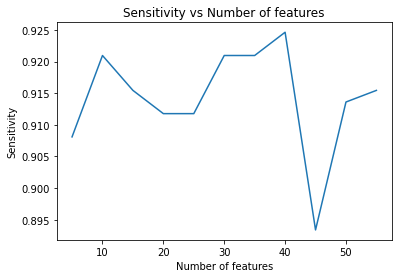

In [ ]:
import matplotlib.pyplot as plt

list_of_sensitivites, list_of_number_of_features = [], []
for number_of_featurs in range(5, 60, 5):
  print("\n====================== Using max_features = ", number_of_featurs)
  list_of_number_of_features.append(number_of_featurs)
  classifier_custom = RandomForestClassifierCustom(5, "entropy", math.inf, 2, number_of_featurs, True, 2000, True)
  classifier_custom.train(X_train, y_train)

  y_pred, test_accuracy = classifier_custom.test(X_test, y_test)

  true_positives = 0
  for i in range(len(y_pred)):
    true_positives = (true_positives+1) if (y_pred[i] == 1 and list(y_test)[i] == 1) else true_positives
  actual_positives = np.bincount(y_test)[1]
  list_of_sensitivites.append(true_positives/actual_positives)
  print("\nSensitivity: ", list_of_sensitivites[-1])

plt.plot(list_of_number_of_features, list_of_sensitivites)
plt.title('Sensitivity vs Number of features')
plt.ylabel('Sensitivity')
plt.xlabel('Number of features')
plt.show()

# Analysis of OOB and Test score over number of features


====================== Using max_features =  5

Height of the tree number 1 : 25

Height of the tree number 2 : 30

Height of the tree number 3 : 23

Height of the tree number 4 : 28

Height of the tree number 5 : 28

Out-Of-Bag Error and Accuracy: 0.09676395939086291 and 0.9032360406091371

Testing Error and Accuracy: 0.07675597393193334 and 0.9232440260680667

====================== Using max_features =  10

Height of the tree number 1 : 26

Height of the tree number 2 : 22

Height of the tree number 3 : 20

Height of the tree number 4 : 20

Height of the tree number 5 : 24

Out-Of-Bag Error and Accuracy: 0.09010152284263961 and 0.9098984771573604

Testing Error and Accuracy: 0.07241129616220132 and 0.9275887038377987

====================== Using max_features =  15

Height of the tree number 1 : 20

Height of the tree number 2 : 19

Height of the tree number 3 : 22

Height of the tree number 4 : 18

Height of the tree number 5 : 19

Out-Of-Bag Error and Accuracy: 0.0897842639593908

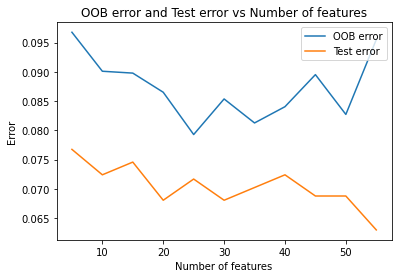

In [ ]:
import matplotlib.pyplot as plt

list_of_oob_errors, list_of_test_errors, list_of_number_of_features = [], [], []
for number_of_featurs in range(5, 60, 5):
  list_of_number_of_features.append(number_of_featurs)
  print("\n====================== Using max_features = ", number_of_featurs)
  classifier_custom = RandomForestClassifierCustom(5, "entropy", math.inf, 2, number_of_featurs, True, 2000, True)
  classifier_custom.train(X_train, y_train)
  list_of_oob_errors.append(1 - classifier_custom.oob_score_)
  
  y_pred, test_accuarcy = classifier_custom.test(X_test, y_test)
  list_of_test_errors.append(1 - test_accuarcy)

plt.plot(list_of_number_of_features, list_of_oob_errors)
plt.plot(list_of_number_of_features, list_of_test_errors)
plt.title('OOB error and Test error vs Number of features')
plt.ylabel('Error')
plt.xlabel('Number of features')
plt.legend(['OOB error', 'Test error'], loc='upper right')
plt.show()
  